In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os
import cv2
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [3]:
def extract_BBoxes(filename):
   
    root = ET.parse(filename).getroot()
    
    boxes = list()
    names = list()
    for objct in root.findall(".//object"):
        name = objct.find('name').text
        xmin = int(objct.find('bndbox/xmin').text)
        ymin = int(objct.find('bndbox/ymin').text)
        xmax = int(objct.find('bndbox/xmax').text)
        ymax = int(objct.find('bndbox/ymax').text)
        names.append(name)
        boxes.append([xmin,ymin,xmax,ymax])

    return [boxes,names]
    
def load_dataset(path, deleteFiles = False):
    files_xml = [f for f in glob.glob(str(path) + "/*.xml")] # comes in random order
    
    imgbbox = dict()
    print(len(files_xml))
    for file in files_xml:  
        
        imgFilePath = file[:-3] + "jpg"
        if os.path.exists(imgFilePath):  
            lbl_bbox = extract_BBoxes(file)  # Gets the bbox information
            
            #print(lbl_bbox[0])
            
            imgbbox.update({imgFilePath.replace(str(path)+"/",''): lbl_bbox})
            
        elif deleteFiles:
            print("Found xml with no jpg")
            print("Deleting xml file: %s" %file)
            os.remove(file)
            print("Deleted")

    return imgbbox

535
(535, 450, 320, 3)


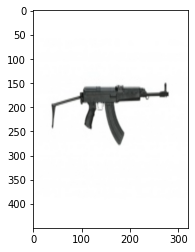

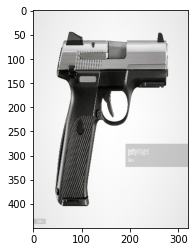

In [5]:
imgbbox = load_dataset('../Project2', deleteFiles=False)
labels = [imgbbox[file][1] for file in imgbbox]

labels = np.array(labels)

path = '../Project2'

imgList = []
for file in os.listdir(path):
    temp = cv2.imread(os.path.join(path,file))
    if temp is not None:
        imgList.append(temp)

images = np.array(imgList)

print(images.shape)

n_categories = 2

x_train = images[0::2]
#x_train = np.asarray(x_train).astype(np.float32)

x_test = images[1::2]
#x_test = np.asarray(x_test).astype(np.float32)

y_train = labels[0::2]

for i in range(len(y_train)):
    if y_train[i] == ['handgun']:
        y_train[i] = 1
        
    else:
        y_train[i] = 2
        
y_train = keras.utils.to_categorical(y_train-1, n_categories)

y_test = labels[1::2]
for i in range(len(y_test)):
    if y_test[i] == ['handgun']:
        y_test[i] = 1
        
    else:
        y_test[i] = 2
y_test = keras.utils.to_categorical(y_test-1, n_categories)

plt.imshow(x_train[6])
plt.figure()
plt.imshow(x_test[6])

# test to verify no duplicates between train and test
for i in range(x_train.shape[0]-1):
    if x_test[i].all == x_train[i].all:
        print("EQUAL")

In [11]:
n, y, x, d = x_train.shape
inputShape = (y,x,d)
n_iterations = 3

model = Sequential()
model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=inputShape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(4, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(2, (2, 2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(units = 2, activation='softmax'))

# compiling model with cross entropy and accuracy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# training model
model.fit(x_train, y_train, epochs=n_iterations, verbose=1, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print("\nAccuracy:\t", accuracy, "\nLoss:\t", loss)

Epoch 1/3
9/9 [==============================] - 4s 454ms/step - loss: 7.4832 - accuracy: 0.5075 - val_loss: 0.6919 - val_accuracy: 0.6816
Epoch 2/3
9/9 [==============================] - 4s 425ms/step - loss: 0.6895 - accuracy: 0.6604 - val_loss: 0.6893 - val_accuracy: 0.6816
Epoch 3/3
9/9 [==============================] - 4s 434ms/step - loss: 0.6863 - accuracy: 0.6604 - val_loss: 0.6864 - val_accuracy: 0.6816

Accuracy:	 0.6816479563713074 
Loss:	 0.6864311099052429
